In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:

# Load the dataset
df = pd.read_csv('/kaggle/input/globalweatherrepository/GlobalWeatherRepository.csv')
df

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.5200,69.1800,Asia/Kabul,1715849100,16-05-2024 13:15,26.6,79.8,Partly Cloudy,...,8.400,26.600,1,1,4:50 AM,6:50 PM,12:12 PM,1:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.3300,19.8200,Europe/Tirane,1715849100,16-05-2024 10:45,19.0,66.2,Partly cloudy,...,1.100,2.000,1,1,5:21 AM,7:54 PM,12:58 PM,2:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.7600,3.0500,Africa/Algiers,1715849100,16-05-2024 09:45,23.0,73.4,Sunny,...,10.400,18.400,1,1,5:40 AM,7:50 PM,1:15 PM,2:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.5000,1.5200,Europe/Andorra,1715849100,16-05-2024 10:45,6.3,43.3,Light drizzle,...,0.700,0.900,1,1,6:31 AM,9:11 PM,2:12 PM,3:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.8400,13.2300,Africa/Luanda,1715849100,16-05-2024 09:45,26.0,78.8,Partly cloudy,...,183.400,262.300,5,10,6:12 AM,5:55 PM,1:17 PM,12:38 AM,Waxing Gibbous,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47547,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1737022500,16-01-2025 06:15,22.1,71.8,Clear,...,6.290,8.140,1,1,6:50 AM,6:25 PM,9:00 PM,8:58 AM,Waning Gibbous,94
47548,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1737018900,16-01-2025 16:15,22.3,72.1,Sunny,...,103.785,104.895,4,10,6:36 AM,5:37 PM,7:54 PM,8:21 AM,Waning Gibbous,96
47549,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1737022500,16-01-2025 13:15,20.9,69.7,Sunny,...,5.550,10.545,1,1,6:33 AM,5:53 PM,8:16 PM,8:27 AM,Waning Gibbous,96
47550,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1737022500,16-01-2025 12:15,27.0,80.5,Patchy rain nearby,...,22.570,22.755,2,2,5:49 AM,6:44 PM,8:53 PM,7:55 AM,Waning Gibbous,96


In [3]:
# Check for missing values
print(df.isnull().sum())

country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Ni

In [4]:
# Fill or drop missing values as appropriate
df.ffill(inplace=True)  # Forward fill as an example  # Forward fill as an example

In [5]:
# Convert 'last_updated' to datetime and extract features
df['last_updated'] = pd.to_datetime(df['last_updated'], dayfirst=True)
df['hour'] = df['last_updated'].dt.hour
df['day'] = df['last_updated'].dt.day
df['month'] = df['last_updated'].dt.month
df['year'] = df['last_updated'].dt.year

In [6]:
# Select features and target variable
features = [
    'temperature_celsius', 
    'humidity', 
    'wind_mph', 
    'air_quality_Ozone', 
    'air_quality_Nitrogen_dioxide', 
    'air_quality_Sulphur_dioxide', 
    'air_quality_PM10', 
    'air_quality_us-epa-index'
]
target = 'air_quality_PM2.5'  # Example target variable

In [7]:
# Normalize the features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [8]:
# Train-test split
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM
X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

In [9]:
from tensorflow.keras.layers import Input

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for PM2.5 prediction
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 50)               │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history  = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2311.6914 - val_loss: 1590.2589
Epoch 2/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1479.5432 - val_loss: 1310.2831
Epoch 3/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1330.1675 - val_loss: 1163.1804
Epoch 4/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1138.1603 - val_loss: 1068.9496
Epoch 5/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1253.9858 - val_loss: 995.1382
Epoch 6/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 917.7438 - val_loss: 931.1596
Epoch 7/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1039.3936 - val_loss: 874.6207
Epoch 8/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 926.8928 - val_loss: 823.4875
Epoch 9/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 793.3135 - val_loss: 775.8137
Epoch 10/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 691.1127 - val_loss: 736.7466
Epoch 11/80
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 756.61

In [11]:
# Make predictions
y_pred = model.predict(X_test)

298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [12]:
from sklearn.metrics import r2_score
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f"Test R2 Score: {r2}")

Mean Squared Error: 145.61074197072466
Mean Absolute Error: 3.716167533045875
Test R2 Score: 0.9281162035963547


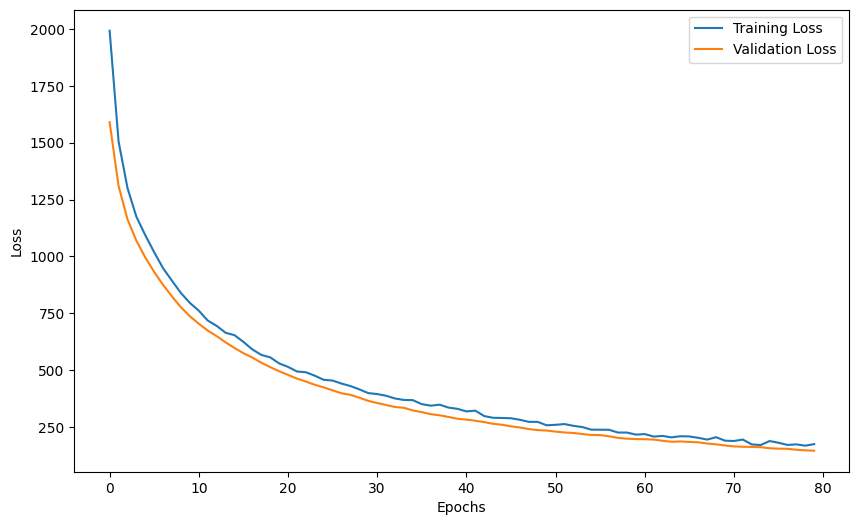

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

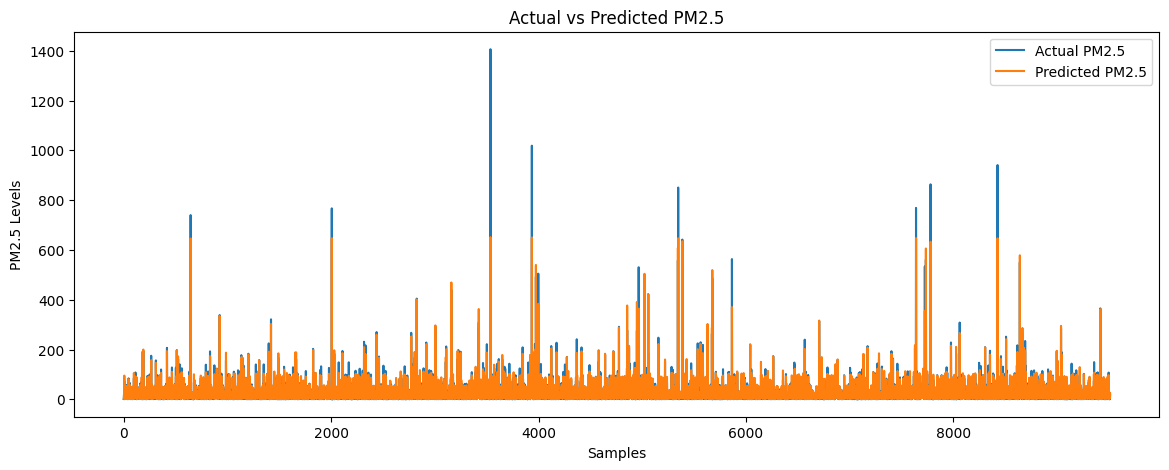

In [14]:
# Visualize results
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label='Actual PM2.5')
plt.plot(y_pred, label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Samples')
plt.ylabel('PM2.5 Levels')
plt.legend()
plt.show()